In [1]:
%reload_ext autoreload
%autoreload 1
%autosave 1

Autosaving every 1 seconds


In [2]:
import os
import sys
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import wandb
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from sklearn.metrics import classification_report

sys.path.append(os.path.pardir)

from src.dataset import ProlivDataset
from src.model import Autoencoder
from src.utils import (
    inference_and_visualize,
    calculate_individual_losses,
    find_best_threshold,
    calculate_labels,
    calculate_tpr_tnr
)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Загрузка датасетов

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((30, 50)),
    transforms.ToTensor()
])

train_dataset = ProlivDataset(os.path.join(os.pardir, "dataset", "train"), 0, transform=transform)
proliv_dataset = ProlivDataset(os.path.join(os.pardir, "dataset", "proliv"), 1, transform=transform)

test_dataset_path = os.path.join(os.pardir, "dataset", "test")
test_labels = os.path.join(test_dataset_path, "test_annotation.txt")

test_dataset = ProlivDataset(os.path.join(os.pardir, "dataset", "test", "imgs"), test_labels, transform=transform)

## Инициализация параметров

In [6]:
batch_size = 128
latent_dims = 128
epochs = 200
lr = 1e-3
shuffle = True

In [7]:
# Create DataLoader
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

autoencoder = Autoencoder(latent_dims=latent_dims).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=lr)

In [26]:
wandb.init(project='itmo-generative-models', entity='ildar-azamatov')

wandb: Currently logged in as: ildar-azamatov. Use `wandb login --relogin` to force relogin


In [28]:
# Configure wandb to log hyperparameters and system stats
wandb.config = {
  "epochs": epochs,
  "batch_size": batch_size,
  "latent_dims": latent_dims,
  "lr": lr,
}

## Обучение

In [29]:
# Adding wandb.watch to log gradients, parameters, and model topology
wandb.watch(autoencoder, log='all')

for epoch in range(wandb.config["epochs"]):
    running_loss = 0.0
    for images, _ in dataloader:
        images = images.to(device)

        # Forward pass
        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    epoch_loss = running_loss / len(dataloader)

    # Logging the metrics to wandb
    wandb.log({"epoch": epoch + 1, "loss": epoch_loss})

    print(f'Epoch [{epoch+1}/{wandb.config["epochs"]}], Loss: {epoch_loss:.10f}')

# wandb.finish()
print('Training completed')

Epoch [1/200], Loss: 0.0017983046
Epoch [2/200], Loss: 0.0015020146
Epoch [3/200], Loss: 0.0014975146
Epoch [4/200], Loss: 0.0014639377
Epoch [5/200], Loss: 0.0013112066
Epoch [6/200], Loss: 0.0012204944
Epoch [7/200], Loss: 0.0011831744
Epoch [8/200], Loss: 0.0011478805
Epoch [9/200], Loss: 0.0011673921
Epoch [10/200], Loss: 0.0009883762
Epoch [11/200], Loss: 0.0008936189
Epoch [12/200], Loss: 0.0008846795
Epoch [13/200], Loss: 0.0008752592
Epoch [14/200], Loss: 0.0008499132
Epoch [15/200], Loss: 0.0008548081
Epoch [16/200], Loss: 0.0008348475
Epoch [17/200], Loss: 0.0008400722
Epoch [18/200], Loss: 0.0008471687
Epoch [19/200], Loss: 0.0008307541
Epoch [20/200], Loss: 0.0008171634
Epoch [21/200], Loss: 0.0008014147
Epoch [22/200], Loss: 0.0007964090
Epoch [23/200], Loss: 0.0007373497
Epoch [24/200], Loss: 0.0007040772
Epoch [25/200], Loss: 0.0006949748
Epoch [26/200], Loss: 0.0006396953
Epoch [27/200], Loss: 0.0006249334
Epoch [28/200], Loss: 0.0006011281
Epoch [29/200], Loss: 0.00058

In [24]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▅▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,200
loss,0.00029


## Инференс

In [ ]:
autoencoder.eval()

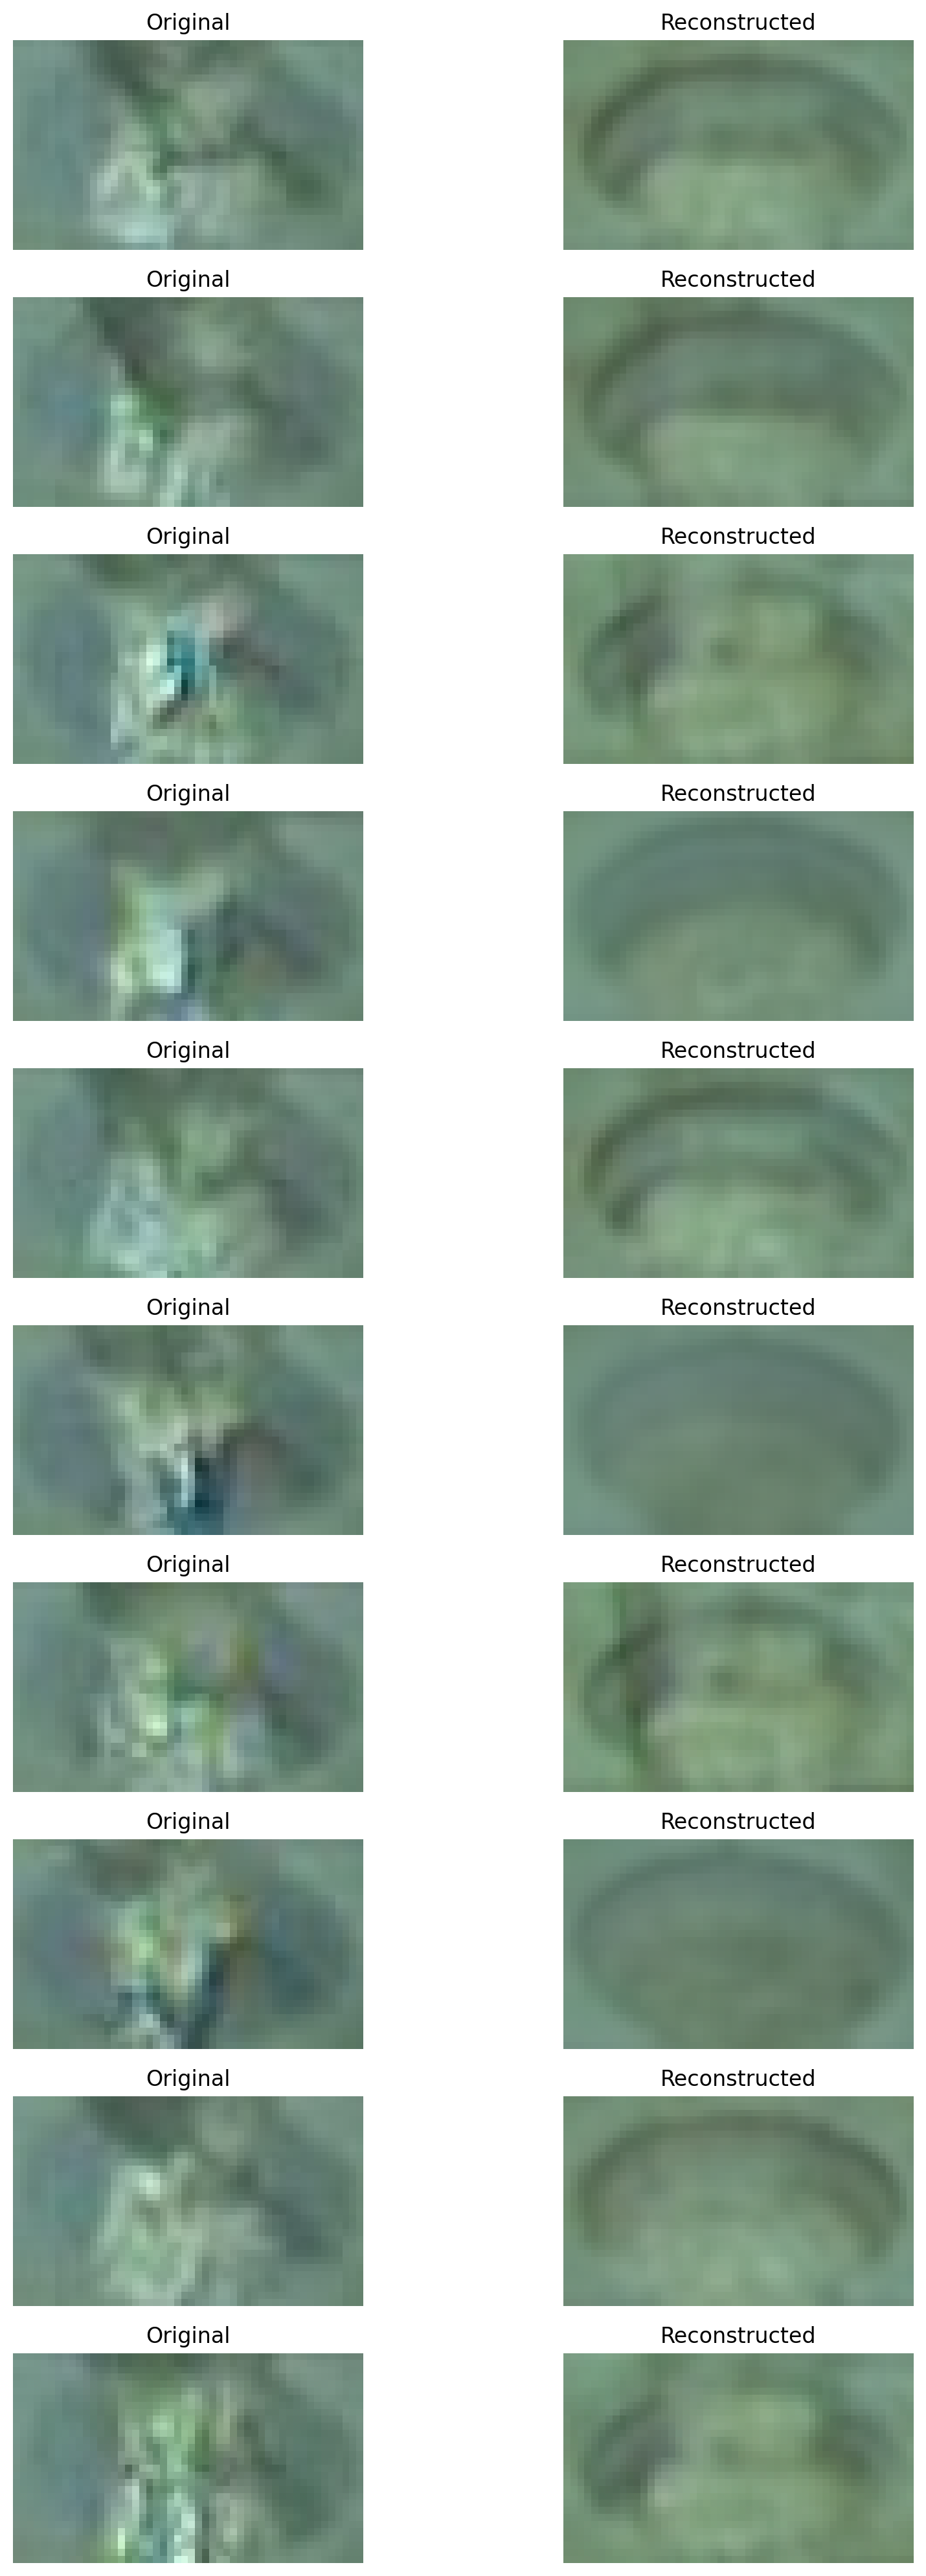

In [30]:
inference_and_visualize(proliv_dataset, autoencoder, device)

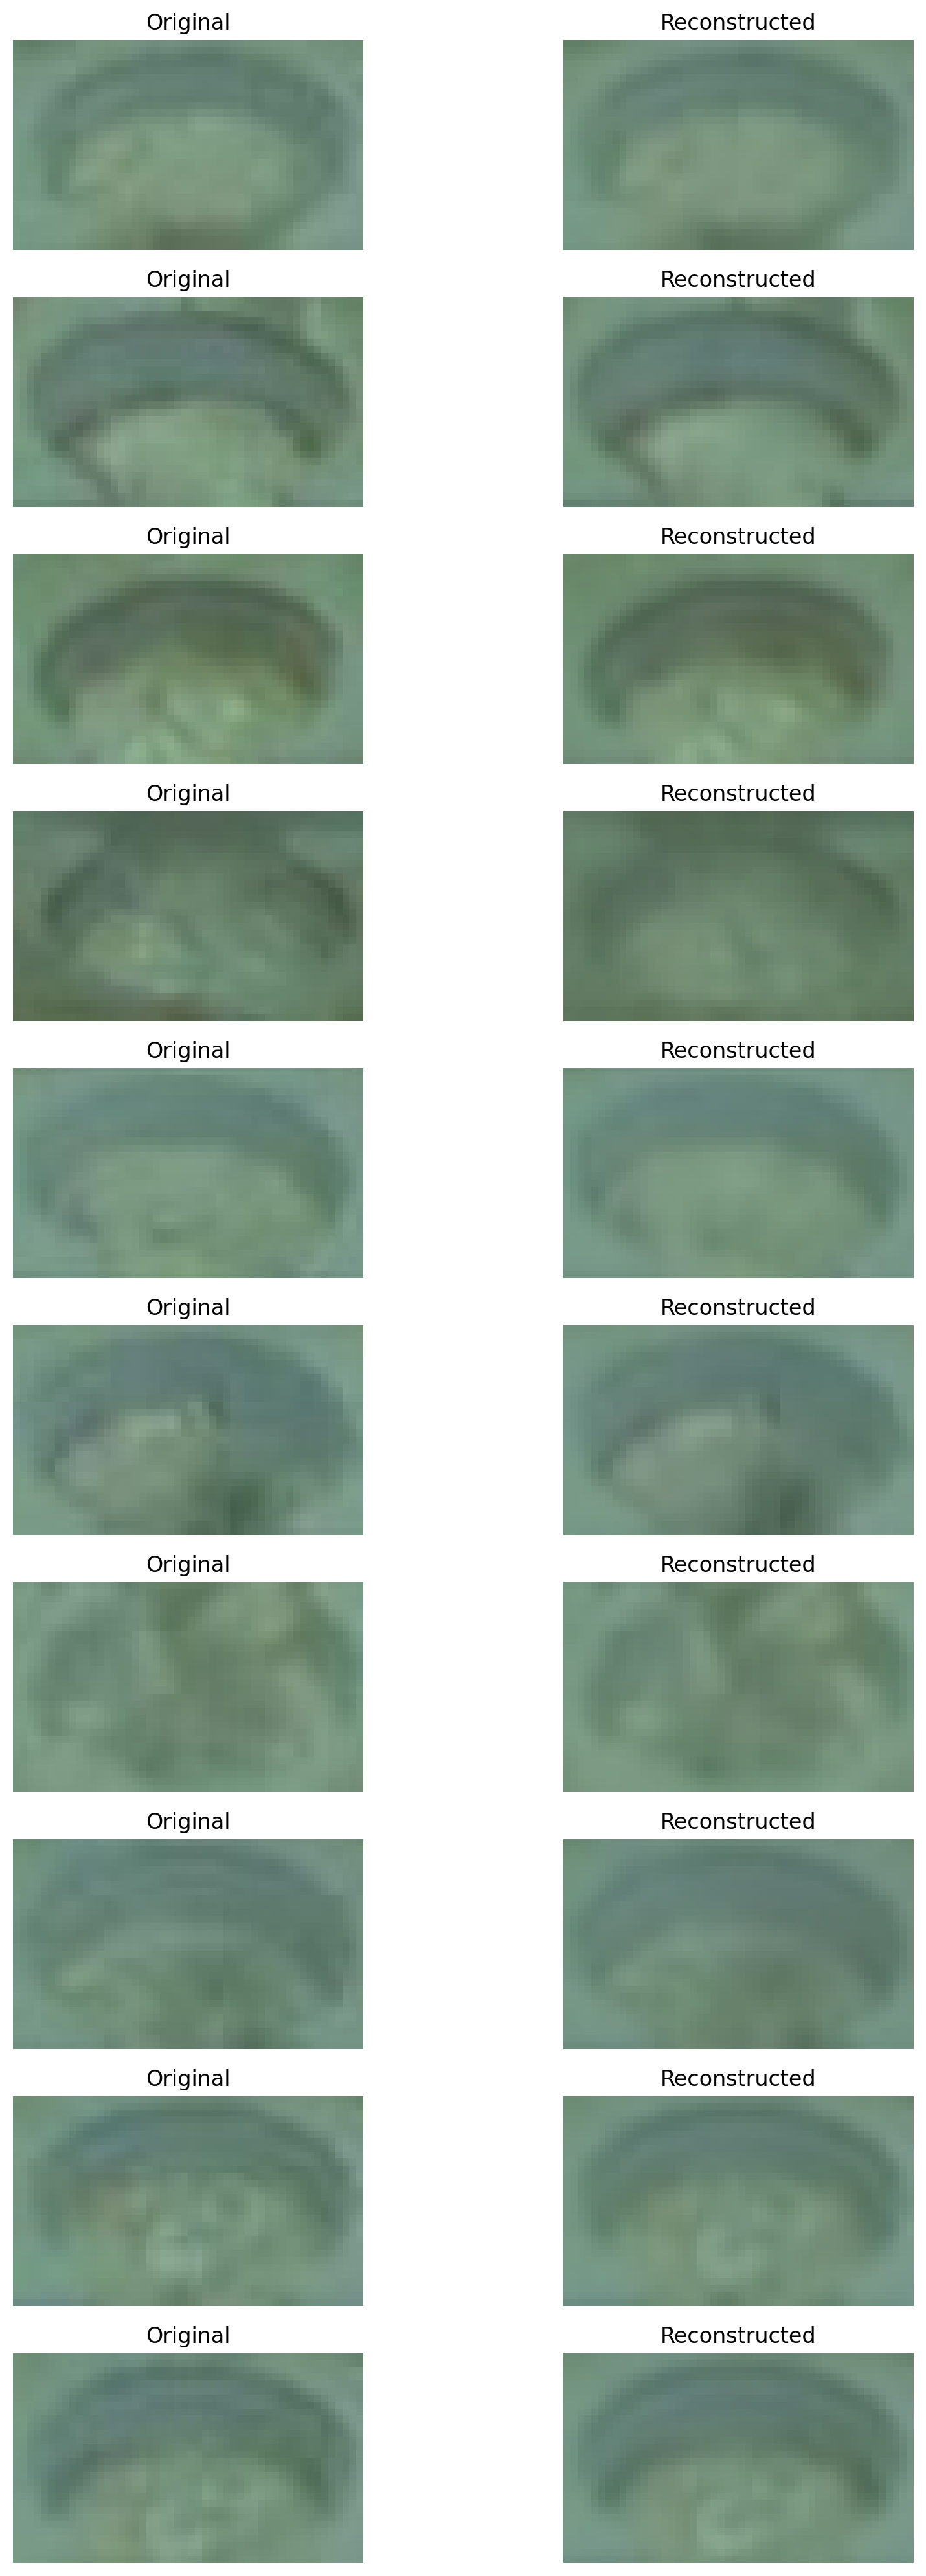

In [31]:
inference_and_visualize(train_dataset, autoencoder, device)

### Ищём threshold для классификации

In [33]:
train_losses = calculate_individual_losses(train_dataset, autoencoder, device)
proliv_losses = calculate_individual_losses(proliv_dataset, autoencoder, device)

In [35]:
best_threshold = find_best_threshold(proliv_losses, train_losses)

In [36]:
best_threshold

0.0029013624880462885

In [38]:
pred = calculate_labels(test_dataset, autoencoder, best_threshold, device)

### Метрики

In [40]:
calculate_tpr_tnr(test_dataset.labels["label"].values, pred)

(0.7906976744186046, 0.8578444747612551)

In [42]:
print(classification_report(test_dataset.labels["label"].values, pred))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3665
           1       0.16      0.79      0.27       129

    accuracy                           0.86      3794
   macro avg       0.58      0.82      0.60      3794
weighted avg       0.96      0.86      0.90      3794

